# Author : Kartik B Bhargav

**Reading material**
* [1] *Oriol Vinyals, Alexander Toshev, Samy Bengio, Dumitru Erhan, "Show and Tell: A Neural Image Caption Generator"*, CVPR, 2015. https://arxiv.org/abs/1411.4555

**Task:**
Implement and test the image caption generator proposed in [1], see further instructions below. 
Please insert your code between two consecutive occurrences of # ...

<b><font color='red'>NOTE</font></b> When submitting your notebook, please make sure that the training history of your model is visible in the output. This means that you should **NOT** clean your output cells of the notebook. Make sure that your notebook runs without errors in linear order.

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pickle
import time
import nltk

#import keras.backend as K
#from tensorflow.keras import Model
#from tensorflow.keras.models import load_model 
#from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, concatenate, Lambda, TimeDistributed
#from tensorflow.keras import losses, optimizers
#from tensorflow.keras.applications import MobileNetV2
#from tensorflow.keras.callbacks import EarlyStopping


from google.colab import drive


In [0]:
import keras.backend as K
from keras import Model
from keras.models import load_model, Model
from keras.layers import Input, Embedding, Dense, LSTM, Dropout, concatenate, Lambda
from keras import losses, optimizers
from keras.applications import MobileNetV2
from keras.callbacks import EarlyStopping
from collections import Counter



In [0]:

# training parameters
embedding_dim = 512
lstm_dim = 500
lstm_dropout = 0.5
batch_size = 100

# Mount Google Drive
We will save the data and our model there, in the folder deeplearning2020_ass3_task1.
**This requires about 600 MB**.


In [50]:
if not os.path.isdir('drive'):
  drive.mount('drive')
else:
  print('drive already mounted')

base_path = os.path.join('drive', 'My Drive', 'deeplearning2020_ass3_task1')
if not os.path.isdir(base_path):
  os.makedirs(base_path)

drive already mounted


# Download Data - Flickr8k

<b><font color='red'>Please don't distribute the dataset</font></b> 

This is a preprocessed version of the Flickr8k dataset, with punctuation and special tokens removed. Furthermore, any word which occurs less than 5 times in the whole corpus has been removed. The images have been rescaled to 128x128 RGB.

**images:** numpy array (8091,128,128,3), uint8, holding 8091 RGB images.

**captions:** collection of 5 human-annotated captions for each image. Stored as a python list of length 8091. 
*   *captions[i]* is a list of length 5, for i=0..8090, holding the 5 annotations for the i'th image.
*   *captions[i][j]* is a caption, represented as a list of strings, for i=0..8090, j=0..4. 
*   For example: *captions[42][3] = ['a', 'young', 'boy', 'wearing', 'a', 'red', 'coat', 'is', 'playing', 'in', 'a', 'long', 'tunnel']*.
*   Thus, there are in total 8091 * 5 = 40455 captions.

<b><font color='red'>Please don't distribute the dataset</font></b> 

In [51]:
if not os.path.isdir('drive'):
  raise AssertionError('Google drive seems to be unmounted -- please run cell above.')
  
flickr_file = os.path.join(base_path, 'Flickr8k_processed.pkl')

if not os.path.isfile(flickr_file):
  start_time = time.time()
  if not os.path.isfile(flickr_file):
    ! wget https://surfdrive.surf.nl/files/index.php/s/kOIDM5tQPzv6IID/download -O Flickr8k_processed.pkl
    shutil.move('Flickr8k_processed.pkl', flickr_file)
  print("Elapsed time: {} seconds.".format(time.time()-start_time))
else:
  print('Found file {}'.format(flickr_file))

images, captions = pickle.load(open(flickr_file, 'rb'))

print('Data loaded.')
print('images: {} {} {}'.format(images.shape, type(images), images.dtype))
print('captions: {} {}'.format(len(captions), type(captions)))

Found file drive/My Drive/deeplearning2020_ass3_task1/Flickr8k_processed.pkl
Data loaded.
images: (8091, 128, 128, 3) <class 'numpy.ndarray'> uint8
captions: 8091 <class 'list'>


# Extract Image Representation

* Use the 'Conv_1' layer from *MobileNetV2* to generate neural codes for each image in the array *images*. 
* Please generate a (8091,20480) numpy array in single precision (dtype=np.float32) holding the neural codes, where each row holds the code for the corresponding row in *images*. 
* Call the resulting array *image_codes*.
* **Hint:** Process the images in batches (of e.g. 200), as the GPU won't be able to process all 8091 images in parallel.
* **Hint:** MobileNetV2 requires images in floating point as inputs, with pixels rescaled to range [-1,1]. In order to save some RAM (and reduce troubles with Colab running out of resources), convert only the batches into single precision, and keep the *images* in their original format (uint8).

In [0]:
def image_gen(images, batch_size=200):
  index = 0
  while True:
        yield (images[index:batch_size + index] / 255 * 2 - 1) #convert images from [-1; 1] to [0; 255]
        index+=batch_size

In [53]:
def get_image_codes(images, batch_size):      
  convnet = MobileNetV2(input_shape=(128,128,3), 
                          include_top=False, 
                          weights='imagenet')
  convnet.summary()

  # ...
  model1 = Model(inputs = convnet.input, outputs=convnet.get_layer("Conv_1").output)
  image_codes = model1.predict(image_gen(images, batch_size), steps=len(images)/batch_size)
  image_codes = image_codes.reshape(8091,20480).astype(np.float32)
  return image_codes
  # ...

image_codes = get_image_codes(images, 200)
print(image_codes.shape)

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

# Analyze Captions

* Find the maximal caption length in the *captions* and store it in a variable *max_caption_length*.
* Construct a collection of all words (i.e. strings) occurring in the captions, and count their occurrences. 
Include the special word '_' (the *stop word*, signaling the end of the captions) in this collection.
* Construct a dictionary *word_to_idx* which maps words to integers as follows:
    *   '_' ->  0
    *   most frequent word -> 1
    *   second most frequent word -> 2
    *   ...

* Construct a dictionary *idx_to_word* which inverts the mapping *word_to_idx*.
* Store the number of unique words, including '_', in a variable *num_words*.

In [0]:
# ...

max_caption_length = np.max([len(words) for single_cap in captions for words in single_cap ])

numb_words = np.array([word for caps in captions for cap in caps for word in cap])
unique, counts = np.unique(numb_words, return_counts=True)
word_dict = dict(zip(unique, counts))


word_dict['_'] = 5 * len(captions) - caption_lengths.count(1)

asc_indices = np.flip(np.argsort(list(word_dict.values())))
asc_word = np.array(list(word_dict.keys()))[asc_indices]
asc_word[[0,1]] = asc_word[[1,0]]

word_to_idx = dict(zip(asc_word, np.arange(len(asc_word))))
idx_to_word = {w: i for i,w in word_to_idx.items()}
num_words = len(word_dict)

# ...

In [0]:
assert word_to_idx['_'] == 0
assert word_to_idx['a'] == 1 #"a" is the most common word

# Train/Validation/Test Split

In [0]:
val_images = images[0:1000, ...]
val_codes = image_codes[0:1000, ...]
val_captions = [captions[k] for k in range(1000)]

test_images = images[1000:2000, ...]
test_codes = image_codes[1000:2000, ...]
test_captions = [captions[k] for k in range(1000, 2000)]

train_images = images[2000:, ...]
train_codes = image_codes[2000:, ...]
train_captions = [captions[k] for k in range(2000, images.shape[0])]

# Convert Train and Validation Data into Matrix Format

This encodes the captions to integer matrices using the mapping *word_to_idx*. 
It also duplicates the corresponding image codes.
The result is two matrices {train, val}_codes and {train, val}_y, which hold image codes and integer encoded captions, whose rows correspond to each other.

In [57]:
def convert_data(codes, captions, max_caption_length, word_to_idx):
  if codes.shape[0] != len(captions):
    raise AssertionError("Different number of codes and captions.")
  
  N = codes.shape[0]
  duplicate_codes = None
  labels = None
  for k in range(5):
    cur_labels = np.zeros((N, max_caption_length), dtype=np.uint32)
    for l in range(N):
      for count, w in enumerate(captions[l][k]):
        cur_labels[l, count] = word_to_idx[w]

    if duplicate_codes is None:
      duplicate_codes = codes
      labels = cur_labels
    else:
      duplicate_codes = np.concatenate((duplicate_codes, codes), 0)
      labels = np.concatenate((labels, cur_labels), 0)
  
  return duplicate_codes, labels

train_codes, train_y = convert_data(train_codes, train_captions, max_caption_length, word_to_idx)
val_codes, val_y = convert_data(val_codes, val_captions, max_caption_length, word_to_idx)

print(train_codes.shape)
print(train_y.shape)
print(val_codes.shape)
print(val_y.shape)

(30455, 20480)
(30455, 35)
(5000, 20480)
(5000, 35)


# Show Random Images from Train and Validation Sets


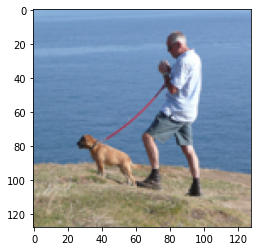

['a', 'man', 'and', 'a', 'dog', 'stand', 'on', 'a', 'hill', 'overlooking', 'water', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





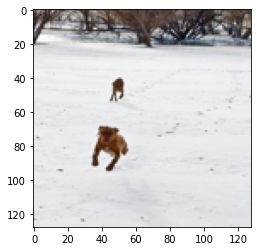

['two', 'brown', 'dogs', 'are', 'running', 'through', 'the', 'snow', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





In [58]:
def show_random_image_and_captions(images, labels, idx_to_word):
  n = images.shape[0]
  idx = np.random.randint(0, n)

  plt.imshow(images[idx % images.shape[0], ...])
  plt.show()

  encoded_caption = labels[idx, ...]
  encoded_caption = [k for k in encoded_caption if k >= 0]
  caption = [idx_to_word[i] for i in encoded_caption]
  print(caption)
  print('\n\n')

show_random_image_and_captions(train_images, train_y, idx_to_word)
show_random_image_and_captions(val_images, val_y, idx_to_word)

# Make Model

The model takes two inputs:

*   *image_input*: placeholder for image codes.
*   *caption_inputs*: placeholder for integer-encoded captions. 

You need to insert the following structure:

*   Image embedding: *Dense* layer, mapping image codes to embeddings of length *embedding_dim*.
*   Caption embedding: *Embedding* layer, mapping integers to embeddings of length *embedding_dim*.
*   Concatenate Image embedding and Caption embeddings along the time axis. The image embedding should be at time t=0.
*   LSTM with *lstm_dim* units, taking the concatenated embedding as input.
*   Apply Dropout with rate 0.5 to the LSTM.
*   Output layer: *Dense* layer, mapping the output of the LSTM to a categorical distribution (via *softmax*) of length *num_words*.

**Hint:** The function K.expand_dims() might be useful here.



In [0]:
def make_model(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout):

  # inputs
  image_input = Input(shape=(code_length,))
  caption_input = Input(shape=(max_caption_length - 1,))

  # ...

  # construct model here

  #Image embedding: Dense layer, mapping image codes to embeddings of length embedding_dim.
  image_embedding = Dense(embedding_dim, name="image_embedding_1")(image_input)
  image_embedding = Lambda(lambda y: K.expand_dims(y, axis=1), name="emb_exp" )(image_embedding)

  #Caption embedding: Embedding layer, mapping integers to embeddings of length embedding_dim.
  caption_embedding = Embedding(max_caption_length-1, embedding_dim, name="emb_word")(caption_input)

  #Concatenate Image embedding and Caption embeddings along the time axis. The image embedding should be at time t=0.
  concat_embedding = concatenate([image_embedding, caption_embedding], axis=1)

  #LSTM with lstm_dim units, taking the concatenated embedding as input.
  lstm_output = LSTM(lstm_dim, dropout=lstm_dropout, return_sequences=True, name="lstm")(concat_embedding) 

  output = Dense(num_words, activation='softmax', name="sm")(lstm_output)
  # ...

  return Model([image_input, caption_input], output)

model = make_model(code_length=train_codes.shape[1], 
                   max_caption_length=max_caption_length, 
                   embedding_dim=embedding_dim, 
                   num_words=num_words, 
                   lstm_dim=lstm_dim, 
                   lstm_dropout=lstm_dropout)

# Train Model

* Use Adam with learning rate 0.001 and early stopping with patience 1. 
Provide the separate validation set for early stopping.
* Use a batch size of 100.
* Use a maximal number of epochs of 100 (early stopping will likely stop training much earlier).
* Use crossentropy as loss function.
* Report which data serves as input and which serves as output, and why.
* **Hint:** Use the sparse version of crossentropy, in order to avoid memory issues.

In [0]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=1,
                                        verbose=1, 
                                        mode='auto')

# ...
#compile the model
model.compile(optimizer=optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
# ...



In [61]:
#model fit
model.fit(x=[train_codes, train_y[:, :-1]], 
          y=np.expand_dims(train_y, axis=-1), 
          epochs=100,
          batch_size=100,
          callbacks=[early_stopping_callback],
          validation_data=([val_codes, val_y[:, :-1]], 
                            np.expand_dims(val_y, axis=-1)))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 30455 samples, validate on 5000 samples
Epoch 1/100
30455/30455 [==============================] - 60s 2ms/step - loss: 1.6859 - sparse_categorical_accuracy: 0.7358 - val_loss: 1.4014 - val_sparse_categorical_accuracy: 0.7522
Epoch 2/100
30455/30455 [==============================] - 59s 2ms/step - loss: 1.3293 - sparse_categorical_accuracy: 0.7595 - val_loss: 1.2772 - val_sparse_categorical_accuracy: 0.7637
Epoch 3/100
30455/30455 [==============================] - 59s 2ms/step - loss: 1.2377 - sparse_categorical_accuracy: 0.7662 - val_loss: 1.2184 - val_sparse_categorical_accuracy: 0.7684
Epoch 4/100
30455/30455 [==============================] - 59s 2ms/step - loss: 1.1853 - sparse_categorical_accuracy: 0.7693 - val_loss: 1.1859 - val_sparse_categorical_accuracy: 0.7714
Epoch 5/100
30455/30455 [==============================] - 59s 2ms/step - loss: 1.1480 - sparse_categorical_accuracy: 0.7716 - val_loss: 1.1611 - val_sparse_categorical_accuracy: 0.7733
Epoch 6/100
30455/304

In [0]:
model.save(os.path.join(base_path, 'model.h5'))

# **Report which data serves as input and which serves as output, and why.**

## **Answer**
The data serves as an input is the neural codes of the images and the captions. The captions which serves as an input does not contain last word. The  output of the data is the distribution of the probability. This distribution happens over all 2992 words. The loss function used is the spare_categorical_crossentropy the probability distribution is compared to the true labels. 

# Evaluate Model

* Evaluate and report the final train and validation loss.

In [63]:
model = load_model(os.path.join(base_path, 'model.h5'))
model.summary()

# ...
train_loss, train_acc = model.evaluate([train_codes, train_y[:, :-1]], np.expand_dims(train_y, axis=-1))
val_loss, val_acc = model.evaluate([val_codes, val_y[:, :-1]], np.expand_dims(val_y, axis= -1))

print("Loss for training: {:.4f}".format(train_loss))
print("Loss for validation: {:.4f}".format(val_loss))
# ...

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 20480)        0                                            
__________________________________________________________________________________________________
image_embedding_1 (Dense)       (None, 512)          10486272    input_9[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
emb_exp (Lambda)                (None, 1, 512)       0           image_embedding_1[0][0]          
____________________________________________________________________________________________

# Make Decoder

* Make a greedy decoder model, which iteratively predicts the most likely word at each time step. The decoder is akin to the trained model above, but with a crucial difference: at time step t (t > 0), the LSTM takes the embedding of the word *predicted at time step t-1* as input. At time t=0, the LSTM takes the image embedding as input.
* The decoder should return the predicted captions, encoded as integer matrix of shape (batch_size, max_caption_length).
* Equip the decoder with the weights of the trained model. 
* **Hint:** You will need to pass on the internal state of the LSTM from time step to time step. To this end, use the argument *return_state=True* when creating the LSTM, and the *initial_state* argument when calling the LSTM. 
* **Hint:** Use the argument *weights* to pass the parameters of the trained model. This should contain the weights for image embedding, word embedding, LSTM, and output layer. Use the methods *get_weights()* and *set_weights()* to this end.
* **Hint:** The functions *K.expand_dims()*, *K.argmax()*, and *K.stack()* might be useful here.

In [0]:
def make_decoder(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout, weights):
  
  # input
  image_input = Input(shape=(code_length,))
  
  # ...
  cap=[]
  embedding_layer=Dense(embedding_dim, name="image_embedding_1")
  exp_layer = Lambda(lambda y: K.expand_dims(y, axis=1), name="emb_exp")
  lstm_layer = LSTM(lstm_dim, dropout=lstm_dropout, return_state=True, name="lstm")
  sm_layer = Dense(num_words, activation='softmax', name='sm')
  pw_layer = Lambda(lambda y: K.argmax(y, axis=-1), name="pw_lay")
  word_embedding_layer = Embedding(max_caption_length-1, embedding_dim, name="emb_word")


  image_embedding = embedding_layer(image_input) 
  image_embedding = exp_layer(image_embedding) 
  output_lstm,  state_1,  state_2 = lstm_layer(image_embedding)
  wp = sm_layer(output_lstm)
  cap.append(wp)
  caption_word = pw_layer(wp)
  for i in range(1, max_caption_length):
    cap_word_emb = word_embedding_layer(caption_word)
    cap_word_emb_expansion=exp_layer(cap_word_emb)
    output_lstm, state_1, state_2 = lstm_layer(cap_word_emb_expansion, initial_state=[state_1, state_2])
    wp = sm_layer(output_lstm)
    cap.append(wp)
    caption_word = pw_layer(wp)
  output = Lambda(lambda y: K.stack(y, axis=1))(cap)
  model = Model(inputs=[image_input], outputs=output)
  for x, w in weights.items():
        model.get_layer(x).set_weights(w)
  # ...
  return model



In [0]:
#...
# Get the weights from trained model, and put them in a list 'weights'.
# dictionary is the better choice to save weights for each layers
name_of_layers = ["image_embedding_1", "lstm", "sm", "emb_word"]
weights = {}
for x in name_of_layers:
    weights[x] = model.get_layer(x).get_weights()

# ...


In [0]:
decoder = make_decoder(code_length=train_codes.shape[1], 
                       max_caption_length=max_caption_length,
                       embedding_dim=embedding_dim,
                       num_words=num_words, 
                       lstm_dim=lstm_dim, 
                       lstm_dropout=lstm_dropout,
                       weights=weights)

In [0]:
decoder.compile(optimizer=optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Predict Test Captions

*   Use the decoder to predict the test captions.
*   Decode them to text using the mapping *idx_to_word*.
*   Show 10 random test images and their predicted captions. Categorize them like in Figure 5 in the paper.
*   Report the 1-gram, 2-gram, 3-gram, and 4-gram BLEU scores of the test predictions. **Hint:** You can use the *nltk* package for this. 


In [0]:
# ...
word_prediction = np.argmax(decoder.predict(test_codes, batch_size=15), axis=-1)
cap_prediction = np.array(list(idx_to_word.values()))[word_prediction]
cap_prediction = [[word for word in cap if word != '_'] for cap in cap_prediction]
# ...

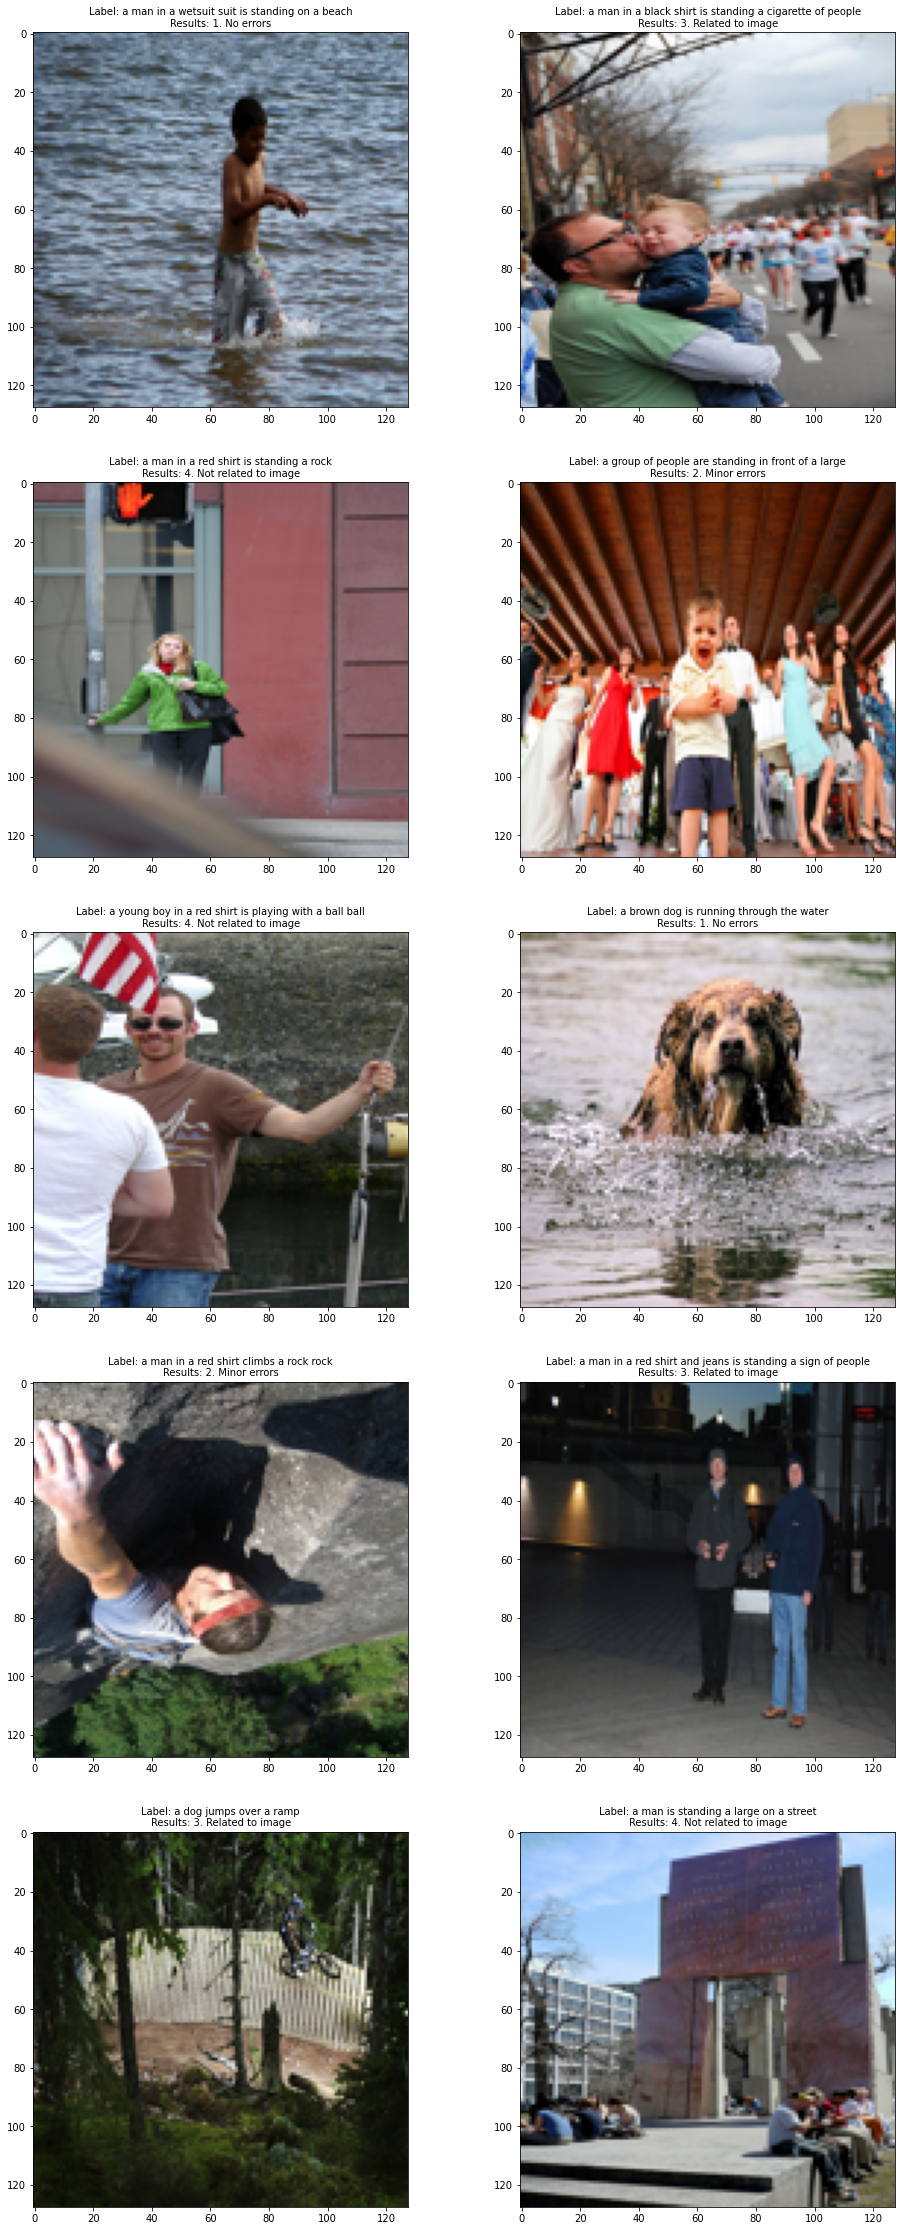

In [75]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 40))
np.random.seed(13)
img_s = np.random.randint(low=0, high = len(test_images), size=10)
caption_to_str = lambda list_caption: " ".join(str(j) for j in list_caption)

results = {1:"1. No errors", 
           2:"2. Minor errors", 
           3:"3. Related to image", 
           4:"4. Not related to image"}

caption_results = [1, 3, 4, 2, 4, 1, 2, 3, 3, 4]

j = 0

for k in axes:
  for sub_plot in k:
    sub_plot.imshow(test_images[img_s[j]])
    sub_plot.set_title("Label: " + caption_to_str(cap_prediction[img_s[j]]) + "\n" +
                      "Results: " + results[caption_results[j]], fontsize=10)    
    j=j+1


In [76]:
from nltk.translate.bleu_score import corpus_bleu

types_gram = {1: (1,0,0,0), 
              2: (0.5,0.5,0,0), 
              3: (1/3,1/3,1/3,0), 
              4: (0.25,0.25,0.25,0.25)}

for i, weight_val in types_gram.items():
    scale = corpus_bleu(test_captions, cap_prediction, weights=weight_val)
    print("Score of BLEU for {}-gram: {}".format(i, scale))

Score of BLEU for 1-gram: 0.538431752178122
Score of BLEU for 2-gram: 0.3447090479396861
Score of BLEU for 3-gram: 0.2136840741236566
Score of BLEU for 4-gram: 0.13256385319638436


#Work Distribution Assignment 3:
##Kartik B Bhargav :- Both of us worked on all the questions and then discussed and finalized the submission. Both Aniket and I contributed equally for the assignment. We both jointly worked through the exercises. We both expect same grade for this assignment.
##Aniket G Ninawe :- The work was equally distributed. The task was split in a fair manner and both got the equal opportunity to work on the assignment. The work is done in collaboration and both got equal opportunity to work on the assignment. Both deserve the same grades.